In [1]:
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt

import os
import cv2
import glob
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from imblearn.over_sampling import SMOTE
import pickle 
import os
import nibabel
import cv2

from sklearn.utils import shuffle
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from skimage import transform

In [2]:
# Meta Data Import
train_df=pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

# Get image path
# Example path: '/kaggle/input/rsna-breast-cancer-detection/train_images/10706/763186195.dcm'
base_path = "/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512/"
all_paths = []
for k in tqdm(range(len(train_df))):
    row = train_df.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + "/" + str(row.image_id) + ".png")
    
train_df["path"] = all_paths
train_df.head()

100%|██████████| 54706/54706 [00:09<00:00, 5985.64it/s]


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...


In [3]:
majority_class_df=train_df[(train_df['cancer'] == 1) 
                           & (train_df['difficult_negative_case'] == False)].sample(1000)
minority_class_df=train_df[(train_df['cancer'] == 0)
                           & (train_df['difficult_negative_case'] == False)].sample(5000)

final_df = pd.concat([majority_class_df, minority_class_df])

final_df=final_df.reset_index(drop=True)

In [4]:
final_df['path'][2]

'/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_512/train_images_processed_512/25679/1160860283.png'

In [5]:
import cv2
import concurrent.futures
import numpy as np
from tqdm import tqdm

output_folder = "/kaggle/working/train_images"

# Create healthy and cancer sub-folders inside output_folder
healthy_folder = os.path.join(output_folder, "healthy")
if not os.path.exists(healthy_folder):
    os.makedirs(healthy_folder)

cancer_folder = os.path.join(output_folder, "cancer")
if not os.path.exists(cancer_folder):
    os.makedirs(cancer_folder)

def process_image(row):
    src_path = row['path']
    patient_id = row['patient_id']
    image_id = row['image_id']
    cancer = row['cancer']

    # Load the PNG image using OpenCV
    img = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)

    # Convert the pixel values to float and normalize them
    img = img.astype(np.float32) / 255.0

    # Resize the image to 256x256
    img_resized = cv2.resize(img, (256, 256))

    # Flip the image if it has MONOCHROME1 photometric interpretation
    if row.get('PhotometricInterpretation') == "MONOCHROME1":
        img_resized = 1 - img_resized

    # Determine the target folder based on the cancer column value
    if cancer == 0:
        target_folder = healthy_folder
    else:
        target_folder = cancer_folder

    # Construct the target path
    target_path = os.path.join(target_folder, f"{patient_id}_{image_id}.png")

    # Save the image to the target folder
    cv2.imwrite(target_path, (img_resized * 255).astype(np.uint8))

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image, row) for index, row in final_df.iterrows()]
    for f in tqdm(concurrent.futures.as_completed(futures), total=final_df.shape[0]):
        pass


100%|██████████| 6000/6000 [00:19<00:00, 308.78it/s]


In [6]:
def count_images(folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            count += 1
    return count

folder_path = "/kaggle/working/train_images/cancer"
image_count = count_images(folder_path)
print("Number of images in cancer folder:", image_count)

folder_path = "/kaggle/working/train_images/healthy"
image_count = count_images(folder_path)
print("Number of images in healthy folder:", image_count)

Number of images in cancer folder: 1000
Number of images in healthy folder: 5000


In [7]:
def view_images_in_both_subfolders(folder_path, num_images=5):
    fig, ax = plt.subplots(nrows=2, ncols=num_images, figsize=(20, 10))
    class_folders = ["healthy", "cancer"]
#     class_folders = ["healthy_corrected", "cancer_corrected"]
    for j, class_folder in enumerate(class_folders):
        class_folder_path = os.path.join(folder_path, class_folder)
        file_names = os.listdir(class_folder_path)
        
        for i, file_name in enumerate(file_names[:num_images]):
                image = plt.imread(os.path.join(class_folder_path, file_name))
                ax[j, i].imshow(image, cmap='jet')
                ax[j, i].set_title(f"{class_folder} - Image Shape: {image.shape}")

    plt.show();

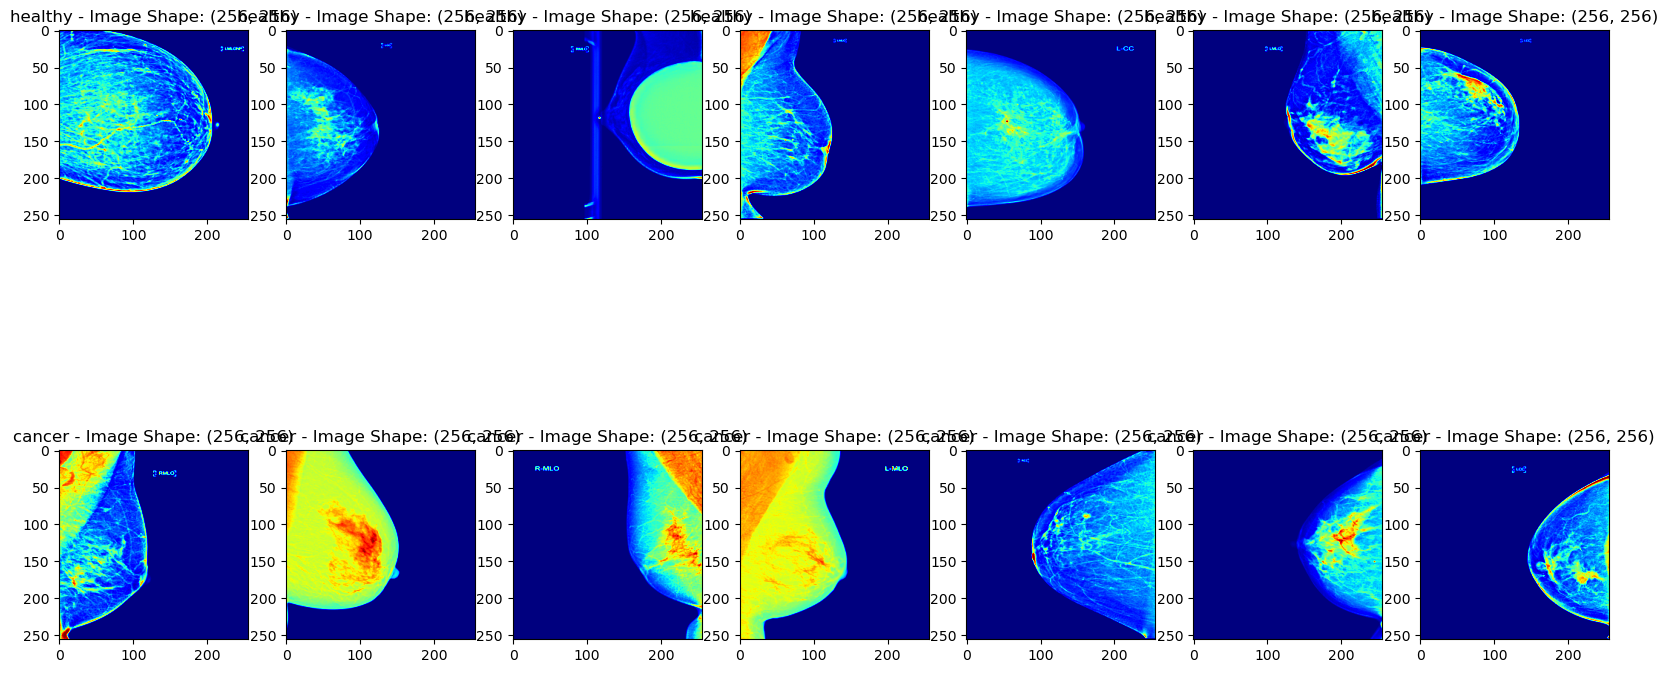

In [8]:
view_images_in_both_subfolders("/kaggle/working/train_images", num_images=7)

In [9]:
def read_nth_image(folder_path, n):
    images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    if len(images) < n:
        return None
    else:
        image_path = os.path.join(folder_path, images[n-1])
        image = cv2.imread(image_path)
        return image

In [10]:
folder_path='/kaggle/working/train_images/cancer/'
n=4
img=read_nth_image(folder_path, n)

In [11]:
img.shape, img.min(), img.max()

((256, 256, 3), 0, 235)

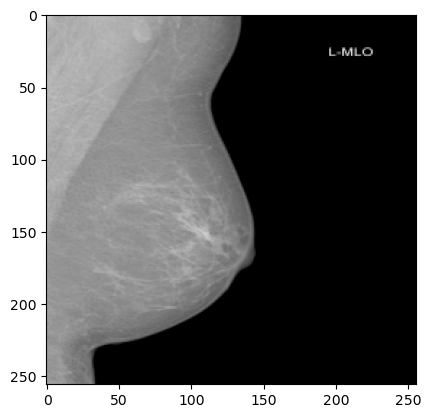

In [12]:
plt.imshow(img, cmap='gray');

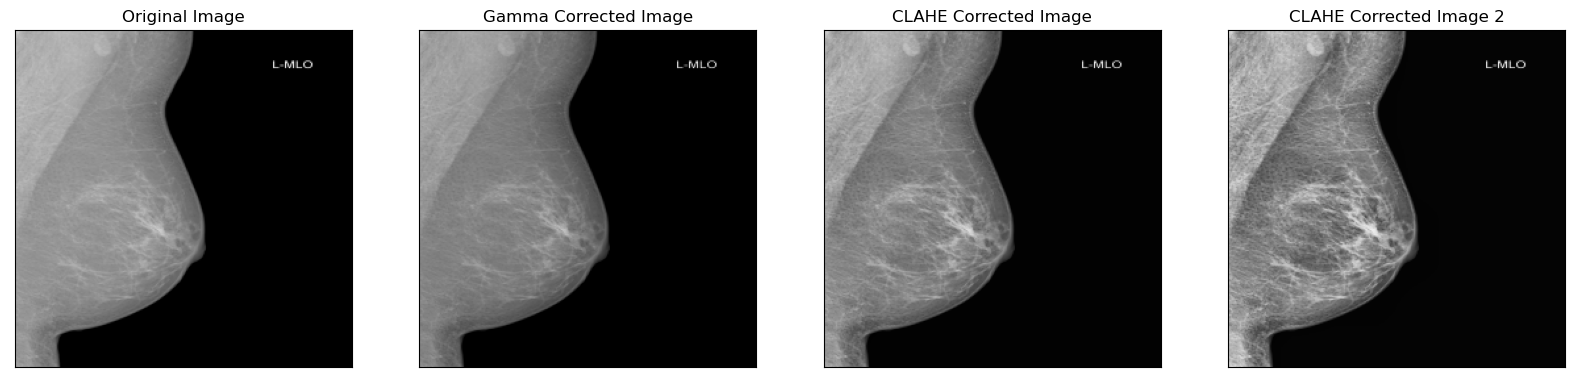

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)], dtype="uint8")

    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(image)
    
    # apply gamma correction to each color channel
    corrected_R = cv2.LUT(R, table)
    corrected_G = cv2.LUT(G, table)
    corrected_B = cv2.LUT(B, table)
    
    # merge the corrected color channels back into a single image
    corrected_image = cv2.merge((corrected_R, corrected_G, corrected_B))
    
    return corrected_image

def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(img)
    
    # apply CLAHE to each color channel
    cl1_R = clahe.apply(R)
    cl1_G = clahe.apply(G)
    cl1_B = clahe.apply(B)
    
    # merge the corrected color channels back into a single image
    cl1 = cv2.merge((cl1_R, cl1_G, cl1_B))
    
    return cl1

# Perform gamma correction with gamma=0.5
gamma_corrected_image = adjust_gamma(img, 0.8)

# Apply CLAHE
clahe_corrected_image = apply_clahe(gamma_corrected_image, clip_limit=1.0, tile_grid_size=(8,8))

# Apply CLAHE
clahe_corrected_image_2 = apply_clahe(clahe_corrected_image, clip_limit=1.0, tile_grid_size=(8,8))

# Display original, gamma corrected, and CLAHE corrected images
plt.figure(figsize=(20,8))
plt.subplot(1,4,1),plt.imshow(img,cmap="gray")
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,2),plt.imshow(gamma_corrected_image,cmap="gray")
plt.title("Gamma Corrected Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,3),plt.imshow(clahe_corrected_image,cmap="gray")
plt.title("CLAHE Corrected Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,4),plt.imshow(clahe_corrected_image_2,cmap="gray")
plt.title("CLAHE Corrected Image 2"), plt.xticks([]), plt.yticks([])

plt.show()

In [14]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)], dtype="uint8")

    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(image)
    
    # apply gamma correction to each color channel
    corrected_R = cv2.LUT(R, table)
    corrected_G = cv2.LUT(G, table)
    corrected_B = cv2.LUT(B, table)
    
    # merge the corrected color channels back into a single image
    corrected_image = cv2.merge((corrected_R, corrected_G, corrected_B))
    
    return corrected_image

def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(img)
    
    # apply CLAHE to each color channel
    cl1_R = clahe.apply(R)
    cl1_G = clahe.apply(G)
    cl1_B = clahe.apply(B)
    
    # merge the corrected color channels back into a single image
    cl1 = cv2.merge((cl1_R, cl1_G, cl1_B))
    
    return cl1

cancer_folder = "/kaggle/working/train_images/cancer/"
healthy_folder = "/kaggle/working/train_images/healthy/"

def process_images(folder_path):
    for filename in os.listdir(folder_path):
        print(os.path.join(folder_path, filename))
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            image = cv2.imread(os.path.join(folder_path, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert from BGR to RGB
            image = adjust_gamma(image)
            image = apply_clahe(image)
            image = apply_clahe(image)
            cv2.imwrite(os.path.join(folder_path, filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [15]:
folder_path = "/kaggle/working/train_images/cancer"
image_count = count_images(folder_path)
print("Number of images in cancer folder:", image_count)


folder_path = "/kaggle/working/train_images/healthy"
image_count = count_images(folder_path)
print("Number of images in healthy folder:", image_count)

Number of images in cancer folder: 1000
Number of images in healthy folder: 5000


In [16]:
import tensorflow as tf
tf.config.threading.set_inter_op_parallelism_threads(4)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import rotate
from sklearn.metrics import roc_auc_score

# set the seed
tf.random.set_seed(42)

# set path to data directory
train_dir='/kaggle/working/train_images'

train_data = ImageDataGenerator(
                                # set data augmentation parameters
#                                 preprocessing_function=custom_augmentation,
                                rescale=1./255,
                                rotation_range=45,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest'
).flow_from_directory(
                      directory=train_dir,
                      batch_size=16,
                      target_size=(256,256),
                      color_mode='rgb',
                      class_mode='binary',
                      seed=42
                    )

Found 6000 images belonging to 2 classes.


In [18]:
# 1. Basic Model
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Reshape((256, 256, 3), input_shape=(256, 256, 3)),
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, 
                         activation="relu"), 
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2), 
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), 
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") 
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# split the data into training and validation sets
val_split = 0.2
x_data, y_data = [], []
for x, y in train_data:
    x_data.append(x)
    y_data.append(y)
    if len(x_data) >= (1 - val_split) / train_data.batch_size:
        break
x_train = np.concatenate(x_data)
y_train = np.concatenate(y_data)
x_val = next(train_data)[0]
y_val = next(train_data)[1]

# fit the model using the training data
history_1 = model_1.fit(x_train, y_train,
                        epochs=20,
                        validation_data=(x_val, y_val))

# evaluate the model on the validation data
val_loss, val_acc = model_1.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# calculate AUC score
y_pred = model_1.predict(x_val)
auc = roc_auc_score(y_val, y_pred)
print("AUC Score:", auc)

Epoch 1/20
1/1 [==============================] - 11s 11s/step - loss: 0.6972 - accuracy: 0.5000 - val_loss: 0.6588 - val_accuracy: 0.8125
Epoch 2/20
1/1 [==============================] - 0s 97ms/step - loss: 0.6528 - accuracy: 0.6875 - val_loss: 0.6057 - val_accuracy: 0.8125
Epoch 3/20
1/1 [==============================] - 0s 144ms/step - loss: 0.6003 - accuracy: 0.6250 - val_loss: 0.5523 - val_accuracy: 0.8125
Epoch 4/20
1/1 [==============================] - 0s 87ms/step - loss: 0.5478 - accuracy: 0.6250 - val_loss: 0.5352 - val_accuracy: 0.8125
Epoch 5/20
1/1 [==============================] - 0s 127ms/step - loss: 0.5020 - accuracy: 0.6250 - val_loss: 0.5502 - val_accuracy: 0.8125
Epoch 6/20
1/1 [==============================] - 0s 91ms/step - loss: 0.4466 - accuracy: 0.7500 - val_loss: 0.5856 - val_accuracy: 0.8125
Epoch 7/20
1/1 [==============================] - 0s 83ms/step - loss: 0.3776 - accuracy: 0.8750 - val_loss: 0.6482 - val_accuracy: 0.6875
Epoch 8/20
1/1 [=========

In [19]:
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(256, 256, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),
  
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),
  
  tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# fit the model using the training data
history_2 = model_2.fit(x_train, y_train,
                        epochs=20,
                        validation_data=(x_val, y_val))

# evaluate the model on the validation data
val_loss, val_acc = model_2.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# calculate AUC score
y_pred = model_2.predict(x_val)
auc = roc_auc_score(y_val, y_pred)
print("AUC Score:", auc)

Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 0.5877 - accuracy: 0.6875 - val_loss: 0.6876 - val_accuracy: 0.6250
Epoch 2/20
1/1 [==============================] - 0s 140ms/step - loss: 0.7921 - accuracy: 0.8125 - val_loss: 0.6779 - val_accuracy: 0.7500
Epoch 3/20
1/1 [==============================] - 0s 99ms/step - loss: 0.3188 - accuracy: 0.8750 - val_loss: 0.6395 - val_accuracy: 0.8125
Epoch 4/20
1/1 [==============================] - 0s 137ms/step - loss: 0.6308 - accuracy: 0.9375 - val_loss: 0.6000 - val_accuracy: 0.8125
Epoch 5/20
1/1 [==============================] - 0s 94ms/step - loss: 0.7813 - accuracy: 0.8750 - val_loss: 0.5650 - val_accuracy: 0.8125
Epoch 6/20
1/1 [==============================] - 0s 92ms/step - loss: 0.2828 - accuracy: 0.9375 - val_loss: 0.5518 - val_accuracy: 0.8125
Epoch 7/20
1/1 [==============================] - 0s 89ms/step - loss: 3.2109 - accuracy: 0.6250 - val_loss: 0.5268 - val_accuracy: 0.8125
Epoch 8/20
1/1 [===========

In [20]:
model_2.save("my_model.h5")

In [21]:
test=pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
test

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [22]:
sample=pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv')
sample

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [23]:
import os
import cv2
import numpy as np
import pandas as pd

# Load test images from folder
test_path = "/kaggle/input/test-images/Test_Png_Files/"
test_images = []
image_ids = []
for file_name in os.listdir(test_path):
    img_id = os.path.splitext(file_name)[0]
    img = cv2.imread(os.path.join(test_path, file_name))
    img = cv2.resize(img, (256, 256))
    test_images.append(img)
    image_ids.append(img_id)

# Convert test images to numpy array
test_images = np.array(test_images)

# Normalize test images
test_images = test_images / 255.0

# Make predictions on test images using model
predictions = model_2.predict(test_images)

# Create DataFrame with image ids and predictions
df = pd.DataFrame({'image_id': image_ids, 'cancer': predictions.flatten()})

# Print DataFrame
print(df)

1/1 [==============================] - 0s 308ms/step
     image_id    cancer
0   736471439  0.969666
1    68070693  0.990631
2   361203119  0.982824
3  1591370361  0.922472


In [24]:
# Convert image_id column to string in both dataframes
test['image_id'] = test['image_id'].astype(str)
df['image_id'] = df['image_id'].astype(str)

# Merge the dataframes on image_id
merged_df = pd.merge(test, df, on='image_id')

In [25]:
merged_df=merged_df[['prediction_id', 'cancer']]
merged_df

,prediction_id,cancer
0,10008_L,0.969666
1,10008_L,0.922472
2,10008_R,0.990631
3,10008_R,0.982824


In [26]:
submission = merged_df.groupby('prediction_id')['cancer'].max()
submission = pd.DataFrame(submission).reset_index()
submission.to_csv('/kaggle/working/submission.csv', index=False)